# PM25 Estimation (Seoul)

## Model

* Regression model: $$y|x \sim N(f^w(x), \tau^{-2}), \quad \tau >0, \tag{Homoscedastic}$$ or $$y|x \sim N(f^w(x), g^w(x)^{-1}), \quad g^w > 0, \tag{Heteroscedastic}$$where $f^w$ and $g^w$ are neural networks with parameter $w$.

* Estimating $f^w$ and $\tau$ (or $g^w$): MLE
    * https://github.com/JavierAntoran/Bayesian-Neural-Networks
    * Gal, Y. (2016). Uncertainty in Deep Learning. PhD Thesis, University of Cambridge, (September). https://doi.org/10.1371/journal.pcbi.1005062

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

## Library

In [2]:
# !pip install pandas numpy torch sklearn torchvision tqdm matplotlib

In [3]:
import pandas as pd
import urllib.request
import os
import time
import copy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import GPy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
import datetime
import matplotlib.dates as mdates
import sys

# from torchvision import datasets, transforms
# from torchvision.utils import make_grid
from tqdm import tqdm, trange
%config InlineBackend.figure_format = 'svg'

## Data

다음과 같은 자료들을 사용하였음

| Data     | Description     | Source                                   |
| -------- | --------------- | ---------------------------------------- |
| PM25     | 일 평균 초미세먼지 농도   | 한국환경공단(www.airkorea.or.kr)               |
| BPM25    | 전일 베이징 초미세먼지 농도 | 미국 국무부 대기 질 모니터링 프로그램 (www.stateair.net) |
| meanTemp | 전일 평균기온         | 기상자료개방포털(data.kma.go.kr)                 |
| minTemp  | 전일 최저기온         | 기상자료개방포털(data.kma.go.kr)                 |
| maxTemp  | 전일 최고기온         | 기상자료개방포털(data.kma.go.kr)                 |
| meanWind | 전일 평균풍속         | 기상자료개방포털(data.kma.go.kr)                 |
| maxWind  | 전일 최대풍속         | 기상자료개방포털(data.kma.go.kr)                 |
| Rain     | 강우 여부           | 기상자료개방포털(data.kma.go.kr)                 |
| lat      | 위도              | TBA                                      |
| long     | 경도              | TBA                                      |

위도, 경도는 추후 공간모형을 고려할 때 사용

In [4]:
# load data
pm25seoul = pd.read_csv("../data/seoul/seoul.csv")

In [5]:
# data processing
no_points = len(pm25seoul)
# y: 다음날
y = pm25seoul['PM25.seoul'].values[1:no_points]
# x: 전날 
x = pm25seoul.drop(['Unnamed: 0', 'Year', 'Month', 'Day', 'PM25.seoul'], axis = 1).values[0:(no_points-1)] 
no_points -= 1
dates = [datetime.datetime(i, j, k).date() for (i, j, k) in 
         zip(pm25seoul.Year.values, pm25seoul.Month.values, pm25seoul.Day.values)]
x_save = x
y_save = y
dates = dates[1:(no_points+1)]

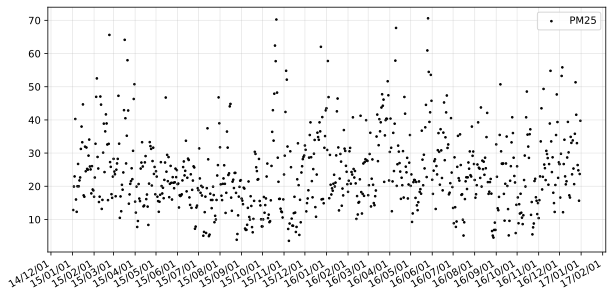

In [6]:
# plotting
plt.figure(figsize = (10, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 30))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
plt.scatter(dates, y_save, color = "black", label = 'PM25', s =3)
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
# fig = px.scatter_3d(pm25seoul, x='meanTemp', y='meanWind', z='PM25.seoul',
#               color='PM25.seoul')
# fig.show()

In [7]:
np.random.seed(1)
train_id = np.random.choice(range(no_points), size = round(0.8*no_points), replace = False)
x_train = x[train_id]
y_train = y[train_id].reshape(-1, 1)

test_id = np.array(list(set(range(no_points)) - set(train_id)))
x_test = x[test_id]
y_test = y[test_id]

## Model

Define models

In [8]:
# 로컬에서는 cpu로 작업
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
import model
import model.loss as loss
import model.dnn as dnn
import model.utils as utils

In [10]:
x_train = x_train.astype(np.float32)
input_dim = x_train.shape[1]
output_dim = 1
num_units = 10

In [11]:
# Laplace
Laplace_homo = dnn.HomoModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)
Laplace_hetero= dnn.HeteroModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)

# Gaussian
Gaussian_homo = dnn.HomoModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)
Gaussian_hetero= dnn.HeteroModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)

# Cauchy
Cauchy_homo = dnn.HomoModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)
Cauchy_hetero= dnn.HeteroModel(input_dim = input_dim, output_dim = output_dim, num_units = num_units).to(device)

In [12]:
modelnames = ["Gaussian", "Laplace", "Cauchy"]

## Training

In [13]:
import model.train as train

In [14]:
lr = 1e-3
num_epochs, batch_size = 20000, len(x_train)

In [15]:
# laplace
train.train_homo(Laplace_homo, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Laplace_homo.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("laplace")
)

train.train_hetero(Laplace_hetero, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Laplace_hetero.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("laplace")
);

100%|██████████| 20000/20000 [00:20<00:00, 973.48it/s] 


In [16]:
# gaussian
train.train_homo(Gaussian_homo, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Gaussian_homo.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("gaussian")
)

train.train_hetero(Gaussian_hetero, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Gaussian_hetero.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("gaussian")
)

100%|██████████| 20000/20000 [00:21<00:00, 940.13it/s] 


In [17]:
# cauchy
train.train_homo(Cauchy_homo, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Cauchy_homo.parameters(), lr = lr), 
            loss_func = loss.log_likelihood("t", df = 1.0)
)

train.train_hetero(Cauchy_hetero, x_train, y_train, num_epochs, 
           optimizer = torch.optim.Adam(Cauchy_hetero.parameters(), lr = lr), 
           loss_func = loss.log_likelihood("t", df = 1.0)
)

  0%|          | 0/20000 [00:00<?, ?it/s]/Users/kwlee/Dropbox/lab/research/VEKorPM/seoul/model/loss.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nlog_coeff = no_dim*(0.5*torch.log(torch.tensor(df_torch*np.pi))
100%|██████████| 20000/20000 [00:20<00:00, 956.14it/s]


## Results

standard deviations:

In [18]:
with torch.no_grad():
    print("Laplace: ", Laplace_homo.log_sigma.item())
    print("Gaussian: ", Gaussian_homo.log_sigma.item())
    print("Cauchy:", Cauchy_homo.log_sigma.item())

Laplace:  1.887008786201477
Gaussian:  2.234485149383545
Cauchy: 2.57930588722229


## Visualize

In [19]:
newx = model.utils.to_device(x_save.astype(np.float32), cuda=False)[0]

In [20]:
# date limits
date_begin = dates[0] - datetime.timedelta(days=5)
date_end = dates[no_points-1] + datetime.timedelta(days=20)

# colors
c = ['#00008b', '#6495ed', '#0000ff'] # prediction
pc = ['#006400', '#8b0000'] # points

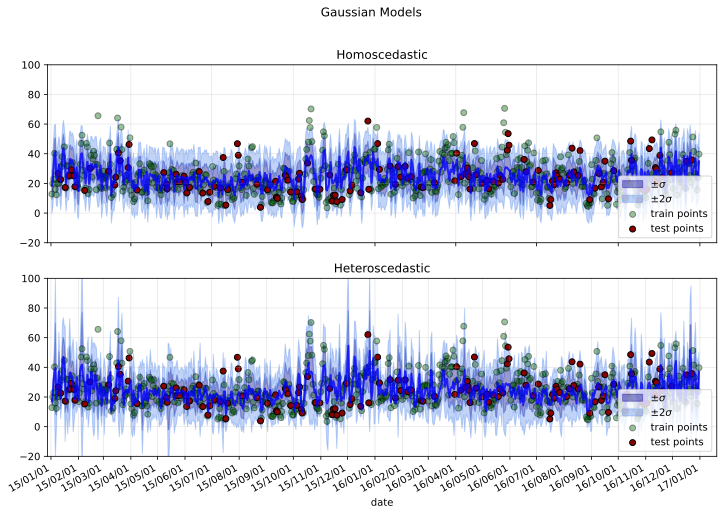

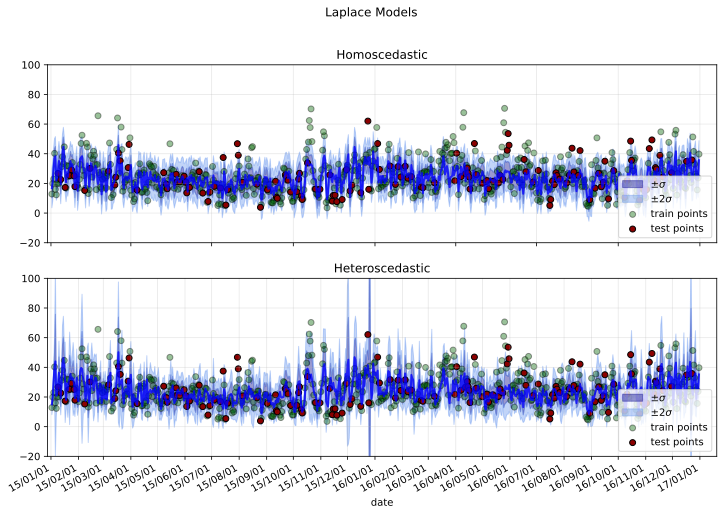

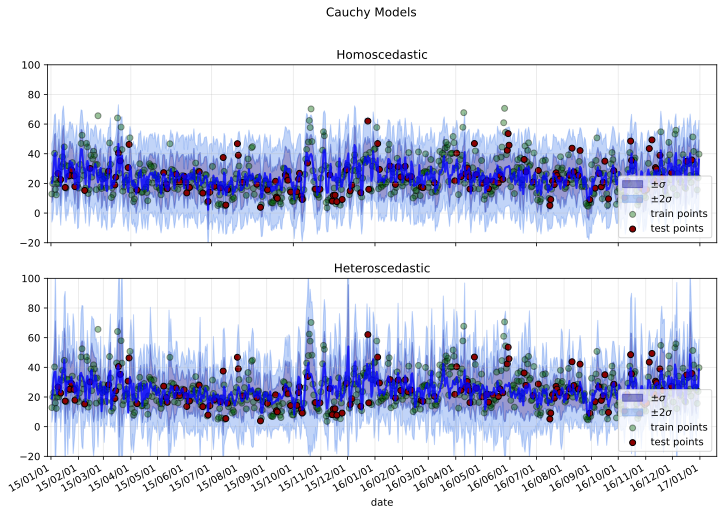

In [21]:
for modelname in modelnames:
    homomodel = getattr(sys.modules[__name__], '{}_homo'.format(modelname))
    heteromodel = getattr(sys.modules[__name__], '{}_hetero'.format(modelname))
    
    homo_means, homo_stds = homomodel.pred(newx)
    homo_means = homo_means.detach().numpy()
    homo_stds = homo_stds.detach().numpy()
    
    hetero_means, hetero_stds = heteromodel.pred(newx)
    hetero_means = hetero_means.detach().numpy()
    hetero_stds = hetero_stds.detach().numpy()
    
    fig, axs = plt.subplots(2, figsize = (12, 8))

    fig.suptitle("{} Models".format(modelname))
    fig.gca().xaxis.set_major_locator(mdates.DayLocator(bymonthday = 1))
    axs[0].fill_between(dates, homo_means - homo_stds, homo_means + homo_stds, color = c[0], alpha = 0.4, label = '$\pm\sigma$')
    axs[0].fill_between(dates, homo_means - 2*homo_stds, homo_means - homo_stds, color = c[1], alpha = 0.4, label = '$\pm2\sigma$')
    axs[0].fill_between(dates, homo_means + homo_stds, homo_means + 2*homo_stds, color = c[1], alpha = 0.4)
    axs[0].scatter(np.array(dates)[train_id.astype(int)], y_train, color = pc[0], label = 'train points', edgecolors= "black", alpha = 0.4)
    axs[0].scatter(np.array(dates)[test_id.astype(int)], y_test, color = pc[1], label = 'test points', edgecolors= "black")
    axs[0].plot(dates,  homo_means, color = c[2], linewidth = 2, alpha = 0.8)
    axs[0].legend(loc = "lower right")
    axs[0].set_title('Homoscedastic')
    axs[0].set_ylim([-20, 100])
    axs[0].grid(alpha = 0.3)
    axs[0].set_xlim([date_begin, date_end])

    axs[1].fill_between(dates, hetero_means - hetero_stds, hetero_means + hetero_stds, color = c[0], alpha = 0.4, label = '$\pm\sigma$')
    axs[1].fill_between(dates, hetero_means - 2*hetero_stds, hetero_means - hetero_stds, color = c[1], alpha = 0.4, label = '$\pm2\sigma$')
    axs[1].fill_between(dates, hetero_means + hetero_stds, hetero_means + 2*hetero_stds, color = c[1], alpha = 0.4)
    axs[1].scatter(np.array(dates)[train_id.astype(int)], y_train, color = pc[0], label = 'train points', edgecolors= "black", alpha = 0.4)
    axs[1].scatter(np.array(dates)[test_id.astype(int)], y_test, color = pc[1], label = 'test points', edgecolors= "black")
    axs[1].plot(dates,  hetero_means, color = c[2], linewidth = 2, alpha = 0.8)
    axs[1].legend(loc = "lower right")
    axs[1].set_title('Heteroscedastic')
    axs[1].set_ylim([-20, 100])
    axs[1].grid(alpha = 0.3)
    axs[1].set_xlim([date_begin, date_end])

    plt.xlabel('date')
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d"))
    plt.gcf().autofmt_xdate()

    plt.show()

## Test Errors

In [22]:
x_test = model.utils.to_device(x_test.astype(np.float32), cuda=False)[0]

In [23]:
mse_table = []
ratio_table = []

for modelname in modelnames:
    homomodel = getattr(sys.modules[__name__], '{}_homo'.format(modelname))
    heteromodel = getattr(sys.modules[__name__], '{}_hetero'.format(modelname))
    
    ratiof = getattr(sys.modules[__name__].utils, '{}_ratio'.format(modelname))
    
    homo_means, homo_stds = homomodel.pred(x_test)
    homo_means = homo_means.detach().numpy()
    homo_stds = homo_stds.detach().numpy()
    
    hetero_means, hetero_stds = heteromodel.pred(x_test)
    hetero_means = hetero_means.detach().numpy()
    hetero_stds = hetero_stds.detach().numpy()
    
    mse_table.append([utils.mse(homo_means, y_test), utils.mse(hetero_means, y_test)])
    ratio_table.append([ratiof(homo_means, y_test, homo_stds), 
                   ratiof(hetero_means, y_test, hetero_stds)])

In [24]:
print("MSE:")
print(pd.DataFrame(data=mse_table,  columns=['Homo', 'Hetero'], index=modelnames))

print("\nRatio:")
print(pd.DataFrame(data=ratio_table,  columns=['Homo', 'Hetero'], index=modelnames))

MSE:
               Homo     Hetero
Gaussian  86.617343  88.085035
Laplace   77.612361  85.327210
Cauchy    80.279343  81.407781

Ratio:
              Homo    Hetero
Gaussian  0.938356  0.897260
Laplace   0.972603  0.958904
Cauchy    1.000000  0.986301
